# **Chapter 5: CPU Scheduling - Introduction**

### **1. What is CPU Scheduling and Why Do We Need It?**

At its core, CPU scheduling is the fundamental technique that makes multiprogrammed operating systems possible and productive.

*   **The Core Idea:** In a single-processor system, only one process can run on the CPU at any given moment. The job of the CPU scheduler is to decide **which one** of the many ready-to-run processes gets to use the CPU next.
*   **The Goal:** By rapidly switching the CPU between different processes (a concept known as **context switching**), the operating system creates the illusion that multiple programs are running simultaneously. This keeps the CPU busy and maximizes overall system productivity, especially when some processes are waiting for I/O operations (like reading a file or waiting for a network packet) to complete.

---

### **2. Key Terminology Clarification**

The text clarifies two important points about terminology that often cause confusion:

*   **Processes vs. Threads:** In modern operating systems, the kernel doesn't actually schedule entire processes. It schedules **kernel-level threads**. However, the terms "process scheduling" and "thread scheduling" are frequently used to mean the same thing. For this chapter:
    *   We will use **"Process Scheduling"** when talking about general, high-level concepts.
    *   We will use **"Thread Scheduling"** when a concept applies specifically to threads.
*   **CPU vs. Core:** As you learned in computer architecture, a single CPU can contain multiple computational units called **cores**. When this chapter says a process is scheduled "on the CPU," it is a simplification. What it really means is that a thread from that process is scheduled to run on one of the CPU's **cores**.

---

### **3. Chapter Objectives: A Roadmap**

This chapter will guide you through the following key areas:

*   **Algorithms:** You will learn about various CPU scheduling algorithms (like Round-Robin, Priority Scheduling, etc.).
*   **Evaluation:** You will learn the criteria (e.g., waiting time, throughput) to assess and compare these algorithms.
*   **Advanced Systems:** We will explore the complexities of scheduling for systems with **multiple processors** or **multicore** CPUs.
*   **Real-Time Systems:** You will be introduced to specialized scheduling algorithms needed for systems with strict timing deadlines (real-time systems).
*   **Real-World Examples:** We will look at how major operating systems like **Windows, Linux, and Solaris** actually implement scheduling.
*   **Analysis & Implementation:** Finally, you will learn how to use modeling to evaluate scheduling algorithms and even how to design a program that implements them.

## **5.1 Basic Concepts**

#### **1. The Core Problem: The CPU is a Single Resource**

In a system with only one CPU core, a fundamental limitation exists: **only one process (or thread) can run at any given moment.** All other processes must wait in a queue for their turn to use the CPU. The goal of an operating system is to manage this waiting and switching efficiently.

---

#### **2. The Goal of Multiprogramming: Maximize CPU Utilization**

The primary objective of **multiprogramming** is to keep the CPU as busy as possible by always having some process running. Here's the simple logic behind it:

*   **The Problem with No Multiprogramming:** Imagine a process that needs to read a large file from the hard disk. It sends the request to the disk (an I/O operation), which is very slow compared to the CPU. In a simple system, the CPU would now sit idle, doing nothing, until the disk drive finishes its work. This is a massive waste of the CPU's computational power.
*   **The Multiprogramming Solution:** Instead of letting the CPU sit idle, the operating system keeps **multiple processes in memory at the same time**. When one process (like our file reader) has to wait for an I/O operation, the OS steps in:
    1.  It takes the CPU away from the waiting process. (This is called a **context switch**).
    2.  It gives the CPU to another process that is ready to run and has work to do.

This cycle continues constantly. Every time one process is forced to wait, the OS can quickly find another process to take over the CPU, ensuring that productive work is nearly always being done.

---

#### **3. Extending to Multicore Systems**

The same principle of keeping the processor busy applies to modern **multicore systems** (CPUs with multiple cores). The goal is simply scaled up: instead of keeping one CPU core busy, the operating system's job is to keep **all** of the cores busy by scheduling processes across them.

---

#### **4. CPU Scheduling is a Fundamental OS Function**

The text emphasizes that scheduling is not an optional feature; it is a **core, fundamental function** of any modern operating system. The CPU is one of the computer's most critical resources, and efficiently managing access to it through scheduling is central to the very design of the OS.

### **5.1.1 CPU–I/O Burst Cycle**

#### **The Fundamental Pattern of Process Execution**

The entire concept of CPU scheduling is built upon a key observation about how processes behave: a process's execution is **not a single, continuous computation**. Instead, it is a cycle that alternates between two main states:

1.  **CPU Burst:** A period where the process is actively executing instructions on the CPU.
2.  **I/O Burst:** A period where the process is waiting for an input/output operation to complete (e.g., reading from a disk, waiting for user input, writing to a network).

**The Cycle of Execution:**
A process's life is a series of these bursts. It starts with a **CPU burst**, then an **I/O burst**, then another **CPU burst**, and so on. This cycle continues until the process finishes, with its final CPU burst ending with a system request to terminate.

*(You should refer to **Figure 5.1** in your text, which visually represents this alternating cycle.)*


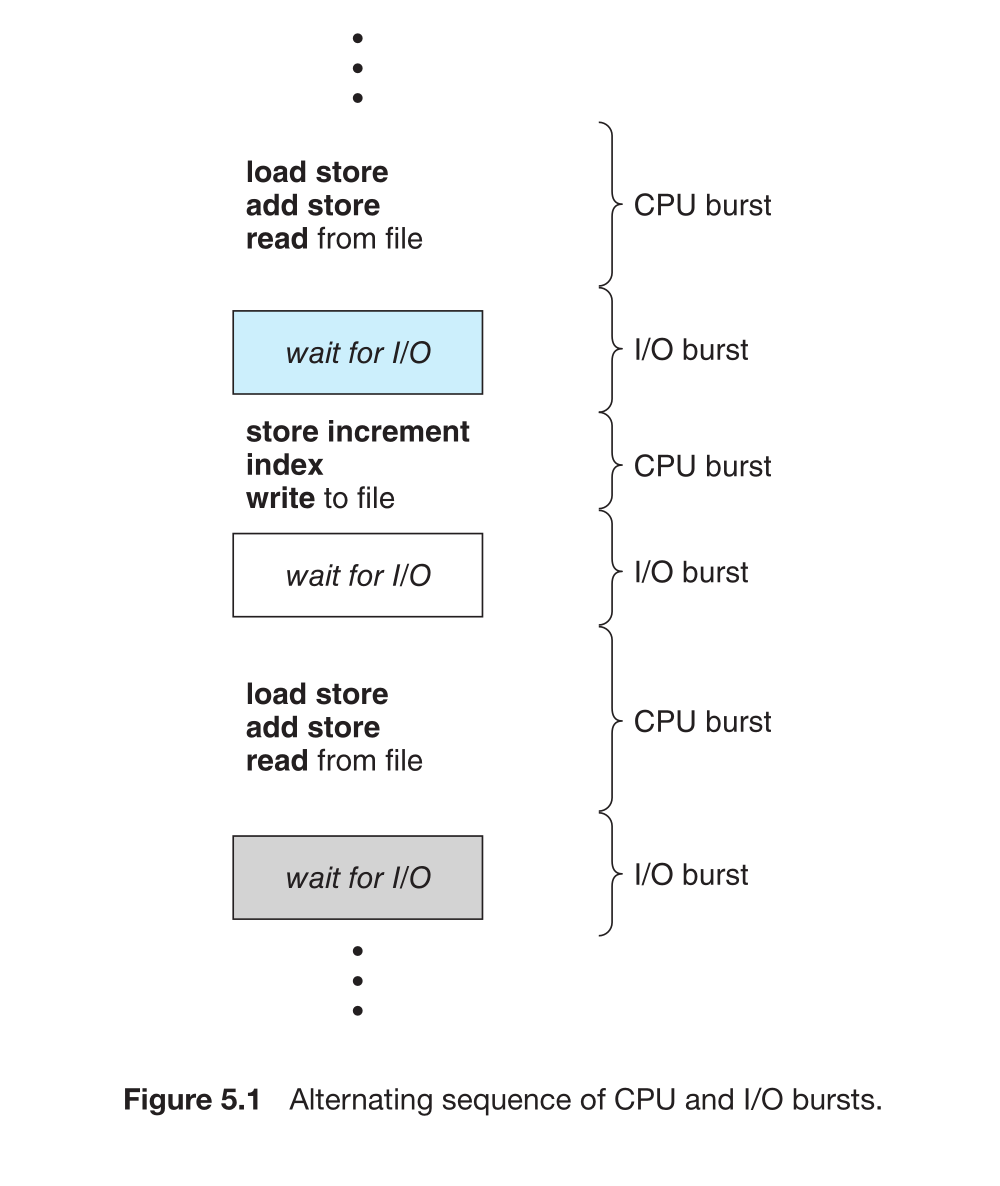




---

#### **The Importance of Burst Duration**

Extensive research has been done to measure the length of these CPU bursts. While the exact durations vary, they follow a predictable pattern, as shown in a frequency histogram.

*(You should refer to **Figure 5.2** in your text, which is a histogram showing the frequency of CPU-burst durations.)*



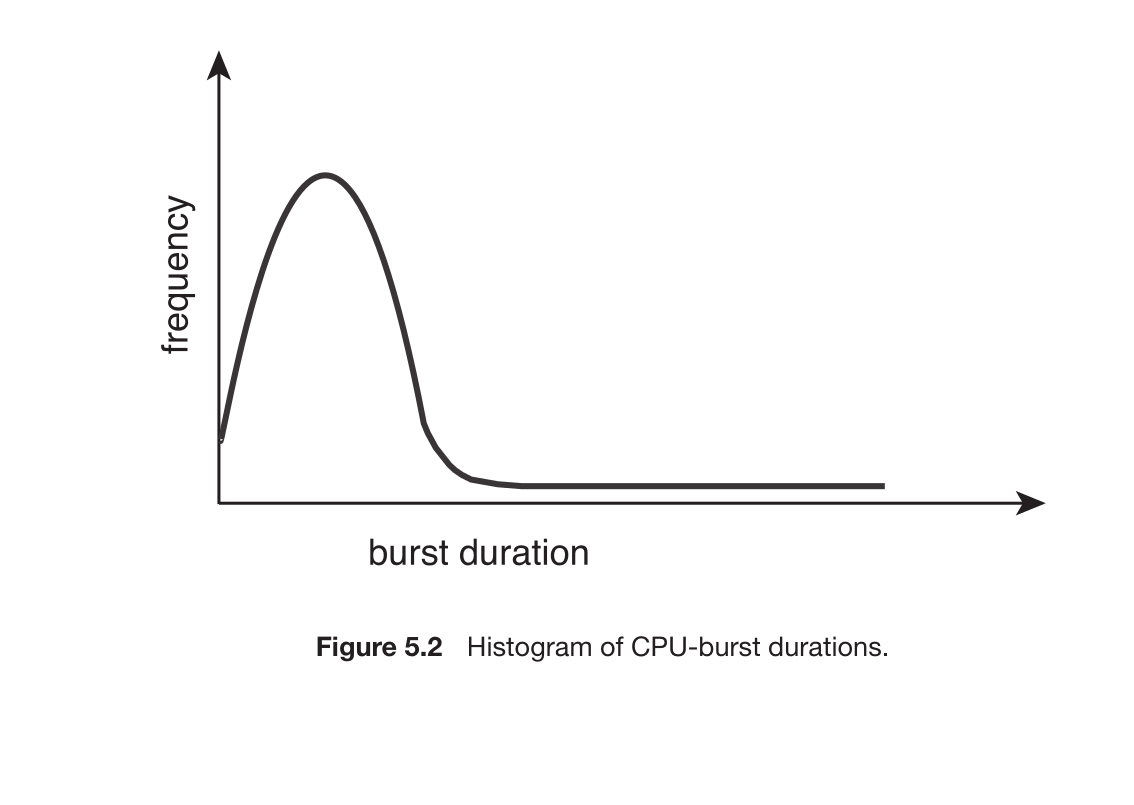





The curve in Figure 5.2 is crucial. It is **exponential or hyperexponential**, meaning:

*   **There are a very large number of short CPU bursts.**
*   **There are a relatively small number of long CPU bursts.**

This distribution is not just a curiosity; it has a direct impact on scheduling. We can categorize programs based on this pattern:

*   **I/O-bound programs:** These programs spend most of their time waiting for I/O. When they get the CPU, they use it only briefly to set up the next I/O request. Therefore, they generate **many short CPU bursts**. Examples: a text editor, a web browser waiting for a click.
*   **CPU-bound programs:** These programs spend most of their time performing intensive computations. They use the CPU for long, uninterrupted periods. Therefore, they generate **a few long CPU bursts**. Examples: a scientific calculation, compiling a large software project.

Understanding this mix of short and long bursts is vital for designing effective CPU-scheduling algorithms, as a good scheduler must handle both types of programs well.

---

### **5.1.2 CPU Scheduler**

#### **The Decision-Maker**

The **CPU scheduler** (often just called the **short-term scheduler**) is the part of the operating system that makes the critical decision of what to run next. Its job is triggered by a specific event: **whenever the CPU becomes idle**.

For example, the CPU becomes idle when:
*   A running process terminates.
*   A running process voluntarily gives up the CPU to wait for an I/O operation.
*   An interrupt occurs.

At that moment, the scheduler must select one process from the **ready queue** and allocate the CPU to it.

---

#### **The Ready Queue**

The **ready queue** is the central list of all processes that are resident in memory, ready to execute, and waiting for the CPU.

Important points about the ready queue:

*   **It's an Abstract Data Structure:** The ready queue is not necessarily a simple first-in, first-out (FIFO) line. Depending on the scheduling algorithm, it can be implemented as:
    *   A **FIFO queue**
    *   A **Priority queue**
    *   A **Tree**
    *   An **unordered linked list**
*   **What's in the Queue?** The entries in the ready queue are typically the **Process Control Blocks (PCBs)** of the processes. The PCB is the kernel data structure that holds all the information the OS needs to manage a process (process state, program counter, CPU registers, etc.).

Conceptually, you can imagine all the ready processes lined up, and the CPU scheduler is the manager that picks the next one to run.

### **5.1.3 Preemptive and Nonpreemptive Scheduling**

#### **When Does Scheduling Happen?**

CPU-scheduling decisions are not random; they occur at specific, well-defined moments when a process changes its state. There are four such circumstances:

1.  **Running → Waiting:** A process voluntarily gives up the CPU because it needs to wait for something (e.g., an I/O operation, or for another process to finish).
2.  **Running → Ready:** A process is forcibly interrupted and moved back to the ready queue (e.g., when a timer interrupt occurs, or a higher-priority process becomes ready).
3.  **Waiting → Ready:** A process finishes waiting (e.g., its I/O operation completes) and is moved back to the ready queue.
4.  **Process Terminates:** A process finishes its execution and exits.

For circumstances **1 and 4**, the OS has **no choice**—the process is done using the CPU, so the scheduler *must* pick a new one from the ready queue.

For circumstances **2 and 3**, the OS *does* have a choice. It can either let the currently running process continue, or it can decide to switch to a different one. This choice defines the two main types of scheduling.

---

#### **Nonpreemptive Scheduling**

*   **Definition:** Under **nonpreemptive** (or **cooperative**) scheduling, the scheduler only takes control during circumstances 1 and 4.
*   **The Rule:** Once a process is given the CPU, it keeps it until it **voluntarily** releases it by terminating or by switching to the waiting state.
*   **Analogy:** It's like having a meeting where a person holds the microphone and keeps it until they are finished speaking and hand it over.
*   **Usage:** This method is simple but is largely obsolete for general-purpose OS cores. Virtually all modern operating systems (Windows, macOS, Linux, UNIX) use preemptive scheduling.

---

#### **Preemptive Scheduling**

*   **Definition:** Under **preemptive** scheduling, the scheduler can take control during circumstances **2 and 3** as well.
*   **The Rule:** The operating system can **forcibly** stop a currently running process, even if it is not finished, and give the CPU to another process.
*   **Analogy:** It's like a debate moderator who can take the microphone away from one speaker to give it to another.
*   **Usage:** This is the standard for all modern operating systems because it provides better system responsiveness and ensures that no single process can monopolize the CPU.

---

#### **The Challenges of Preemption**

Preemptive scheduling is powerful but introduces two major complications:

**1. Race Conditions on Shared Data:**
*   **The Problem:** Imagine two processes sharing a variable. Process A is in the middle of updating the variable when it gets preempted. Process B then runs and reads the variable, but it reads an intermediate, inconsistent value because Process A didn't finish its update.
*   **The Solution:** This problem requires **synchronization mechanisms** (like mutex locks and semaphores) to protect shared data. This is a central topic of **Chapter 6**.

**2. Design of the Operating-System Kernel:**
*   **Nonpreemptive Kernel:** In this design, a process executing a system call in the kernel cannot be preempted until it finishes the call or blocks for I/O. This is simple and safe because kernel data structures cannot be left in an inconsistent state by a preemption. However, it is bad for **real-time computing** as it can cause long, unpredictable delays.
*   **Preemptive Kernel:** In this design, a process can be preempted even while it is executing in the kernel. This is better for responsiveness and real-time systems but requires the kernel itself to be carefully written using synchronization mechanisms (like mutex locks) to protect all its internal data structures from concurrent access. **Most modern OS kernels are preemptive.**

**Handling Interrupts:**
The text also notes that the kernel must handle interrupts carefully. To prevent corruption, small, critical sections of kernel code will temporarily **disable interrupts** at the start and **re-enable** them at the end. This ensures that a sequence of instructions that must run together is not interrupted. These sections are kept very short to avoid missing important hardware signals.

---

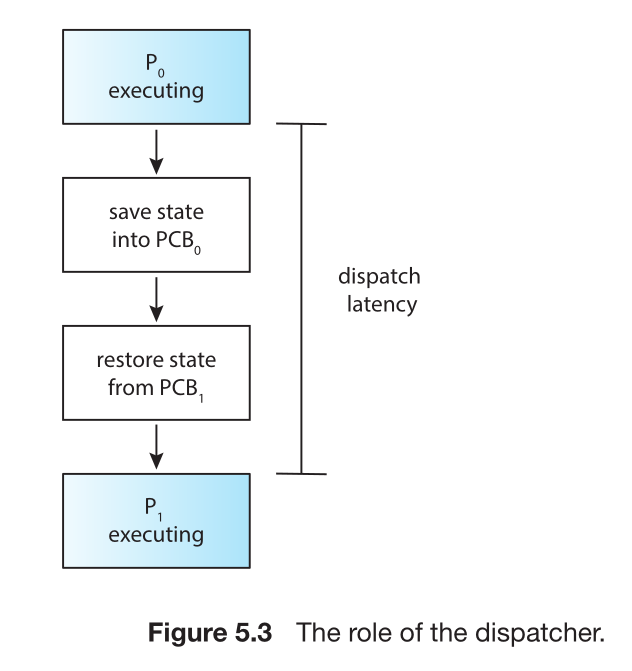



*(You should refer to **Figure 5.3** in your text, which illustrates the role of the dispatcher, the module that handles the actual context switch after the scheduler has made its decision.)*

### **5.1.4 Dispatcher**

#### **The "Switch" in Context Switching**

The **CPU Scheduler** is the brain that *decides* which process runs next. The **Dispatcher** is the muscle that carries out that decision. It is the kernel module responsible for actually transferring control of the CPU core to the newly selected process.

---

#### **The Dispatcher's Job Description**

When the dispatcher is activated, it performs a precise sequence of actions:

1.  **Performing a Context Switch:**
    *   It saves the state of the currently running process (like its program counter, CPU registers) into its **Process Control Block (PCB)**.
    *   It loads the saved state of the new process from its PCB into the CPU registers and its program counter into the CPU's program counter register.

2.  **Switching to User Mode:**
    *   The CPU switches from privileged **kernel mode** (where the OS scheduler and dispatcher run) back to unprivileged **user mode**, where the user process will execute.

3.  **Jumping to the User Program:**
    *   Finally, the dispatcher jumps to the location in the user program that was saved in the program counter, resuming the program's execution exactly where it left off.

---

#### **Dispatch Latency: The Cost of Switching**

The time it takes for the dispatcher to complete this entire process—stopping one process and starting another—is called the **dispatch latency**.

*(You should refer to **Figure 5.3** in your text, which visually breaks down this latency.)*

**Why is this important?** The dispatcher is invoked during *every* process/thread switch. This time is pure overhead; the CPU is doing administrative work instead of running user programs. Therefore, the dispatcher must be engineered to be **extremely fast** to minimize this overhead and maximize useful CPU time.

---

#### **How Often Do Context Switches Occur?**

Context switching happens very frequently. The text shows how to measure this on a Linux system.

*   **System-Wide View with `vmstat`:**
    *   The command `vmstat 1` provides system statistics every second.
    *   The `cs` column shows the number of context switches.
    *   In the example, the system averaged 24 context switches per second since boot, with 225 and 339 context switches in two recent one-second intervals. This shows that context switching is a constant and heavy activity.

*   **Per-Process View with `/proc`:**
    *   You can examine the file `/proc/<PID>/status` for any running process.
    *   This file shows two key statistics:
        *   **voluntary_ctxt_switches:** This occurs when a process **gives up** the CPU itself, typically because it needs to wait for an I/O operation. (e.g., 150 times in the example).
        *   **nonvoluntary_ctxt_switches:** This occurs when the OS **takes away** the CPU from the process, such as when its time quantum expires or a higher-priority process becomes ready. (e.g., 8 times in the example).

This distinction is crucial. A high number of voluntary switches often indicates an I/O-bound process, while a high number of nonvoluntary switches might indicate a CPU-bound process that the OS must preempt to be fair to others.

## **5.2 Scheduling Criteria**

#### **How Do We Judge a Scheduling Algorithm?**

Different CPU-scheduling algorithms have different strengths and weaknesses. To compare them objectively and decide which one is best for a given situation, we use a set of standard performance metrics. The choice of which metric to prioritize can completely change which algorithm is considered "best."

Here are the key criteria used for evaluation:

---

#### **The Five Key Metrics**

1.  **CPU Utilization**
    *   **What it is:** The percentage of time the CPU is busy doing useful work. We want to keep this as high as possible.
    *   **Range:** Conceptually 0% to 100%. In a real system, it typically ranges from 40% (lightly loaded) to 90% (heavily used).
    *   **How to measure:** You can use commands like `top` on Linux/macOS.

2.  **Throughput**
    *   **What it is:** The amount of work completed per unit of time. Specifically, it's the number of processes that finish their execution per second (or minute, etc.).
    *   **Context Matters:** For long-running processes, throughput might be low (e.g., 1 process per second). For short transactions, it should be very high (e.g., 1000 processes per second).

3.  **Turnaround Time**
    *   **What it is:** The total time taken from when a process is submitted to the system until it finally completes. This is the process's perspective on its total lifetime in the system.
    *   **Formula:** Turnaround Time = (Time of Completion) - (Time of Submission). It is the sum of all time spent waiting in the ready queue, executing on the CPU, and performing I/O.

4.  **Waiting Time**
    *   **What it is:** This is the specific amount of time a process spends waiting in the **ready queue**. The scheduling algorithm directly affects this metric.
    *   **Crucial Point:** The scheduler has **no control** over how long a process needs to run on the CPU or perform I/O. Its only influence is on how long the process sits in line waiting for its turn. Therefore, minimizing waiting time is a primary goal of a good scheduler.

5.  **Response Time**
    *   **What it is:** This is specific to **interactive systems**. It is the time from when a request is submitted (e.g., the user presses 'Enter') until the system produces its **first response** (e.g., the first character appears on the screen). It measures how quickly the system starts to respond, not how long it takes to finish the task.
    *   **Why it matters:** For a user, a system that starts responding immediately *feels* much faster, even if the total job takes the same amount of time.

---

#### **Optimization Goals and Nuances**

*   **The General Rule:** We want to **maximize** CPU Utilization and Throughput, and **minimize** Turnaround Time, Waiting Time, and Response Time.
*   **Average vs. Extreme Values:** We usually optimize for the **average** case (e.g., average waiting time). However, sometimes we care about the **worst** case. For example, to ensure fairness, we might want to minimize the *maximum* response time any user experiences.
*   **The Importance of Predictability (Variance):** For interactive systems, a **predictable and consistent** response time is often more desirable than a faster but highly variable one. A system that usually responds in 0.1 seconds but sometimes takes 5 seconds feels sluggish and frustrating. Unfortunately, minimizing variance is a complex problem and not a primary focus of most common scheduling algorithms.

---

#### **A Note on Our Examples**

In the following sections, we will illustrate different scheduling algorithms with simplified examples. To keep things clear:

*   We will represent each process by a single **CPU burst** time in milliseconds.
*   Our primary metric for comparison will be the **average waiting time**.
*   Remember that real processes have many alternating CPU and I/O bursts, and more complex evaluation methods (discussed in Section 5.8) are needed for a full analysis.

## **5.3 Scheduling Algorithms**

#### **Introduction to Scheduling Algorithms**

This section introduces the core algorithms that the CPU scheduler uses to solve its central problem: **deciding which process in the ready queue gets to use the CPU next.**

We will explore several different algorithms, each with its own strategy and characteristics. It's important to understand that the choice of algorithm has a direct and significant impact on the performance metrics we just learned about (waiting time, response time, etc.).

---

#### **A Note on the Scope of Our Discussion**

To keep the initial explanations clear and focused on the fundamental concepts, we will describe all these algorithms under a specific, simplified assumption:

*   We are working with a system that has only **a single CPU with a single core**.
*   This means the system is physically capable of running **only one process at a single point in time**.

This single-core model allows us to understand the pure logic of each algorithm without the added complexity of managing multiple cores simultaneously. Later, in **Section 5.5**, we will expand this discussion to cover the more complex scheduling issues that arise in **multiprocessor and multicore systems**.

### **5.3.1 First-Come, First-Served (FCFS) Scheduling**

#### **The Simplest Algorithm**

The **First-Come, First-Served (FCFS)** scheduling algorithm is the most straightforward approach. The rule is simple: the process that requests the CPU first is the one that gets it first.

*   **Implementation:** It is easily managed with a **First-In, First-Out (FIFO) queue**.
    1.  When a process enters the ready queue, its PCB is added to the **tail** of the queue.
    2.  When the CPU becomes free, it is allocated to the process at the **head** of the queue.
    3.  That process is then removed from the queue.
*   **Advantage:** The algorithm is very simple to code and understand.

---

#### **The Problem: Poor Average Waiting Time**

The main disadvantage of FCFS is that it can lead to very long **average waiting times**, especially when the order of process arrival is unlucky.

Let's analyze an example with three processes arriving at time 0:

| Process | Burst Time (ms) |
| :------ | :-------------- |
| P1      | 24              |
| P2      | 3               |
| P3      | 3               |

**Scenario 1: Order P1, P2, P3**

The Gantt chart (a bar chart showing the schedule) would look like this:

```
|---- P1 -----|-- P2 --|- P3 -|
0             24       27     30
```

*   **Waiting Times:**
    *   P1: 0 ms (runs immediately)
    *   P2: 24 ms (waits for P1 to finish)
    *   P3: 27 ms (waits for P1 and P2 to finish)
*   **Average Waiting Time:** (0 + 24 + 27) / 3 = **17 ms**

**Scenario 2: Order P2, P3, P1**

Now, let's see what happens if the shorter processes arrive first:

```
|-- P2 --|- P3 -|---- P1 -----|
0        3      6             30
```

*   **Waiting Times:**
    *   P2: 0 ms
    *   P3: 3 ms
    *   P1: 6 ms
*   **Average Waiting Time:** (0 + 3 + 6) / 3 = **3 ms**

This demonstrates a massive improvement just by changing the order. The key takeaway is that **FCFS can result in a very high average waiting time, which is not minimal and is highly dependent on the arrival order of processes.**

---

#### **The Convoy Effect**

FCFS can cause a serious performance problem known as the **convoy effect**.

*   **The Situation:** Imagine one **CPU-bound** process (with a long CPU burst) and many **I/O-bound** processes (with very short CPU bursts).
*   **What Happens:**
    1.  The CPU-bound process gets the CPU and holds it for a long time.
    2.  Meanwhile, all the I/O-bound processes finish their I/O quickly and enter the ready queue, where they are stuck waiting for the long process.
    3.  During this wait, the now-idle **I/O devices are unused**.
    4.  Finally, the CPU-bound process finishes and moves to an I/O device. Now the short processes quickly run through their CPU bursts and go back to I/O.
    5.  This leaves the **CPU idle** until the long CPU-bound process finishes its I/O and gets the CPU again.
*   **The Result:** The short processes are "convoyed" behind the slow, long process, leading to low **both CPU and I/O device utilization**.

---

#### **Nonpreemptive Nature**

The FCFS algorithm is **nonpreemptive**. Once a process gets the CPU, it keeps it until it voluntarily terminates or blocks for I/O.

*   **Consequence for Interactive Systems:** This makes FCFS **terrible for interactive systems**. Allowing one process to hold the CPU for an extended period would make the entire system feel unresponsive, as no other process could run until the current one decided to yield.